RSA-2048 이나 RSA-4096 같은 실전 암호키는 현재의 Shor 알고리즘으로 해독하기에 큐비트 수와 오류로 인해 한계가 있다. 따라서 아래의 코딩에서는 Shor 알고리즘을 작은 수(N=15)에 대해 시뮬레이션하는 방식으로 구현하고자 한다. 앞서 설명된 것처럼, RSA 암호는 두 개의 큰 소수 p, q 의 곱으로 이루어진 모듈러스 n = p X q 를 공개키로 사용하며, 그 보안성은 n을 효율적으로 소인수분해하기 어렵다는 수학적 난제에 기반한다 . 그러나 Shor 알고리즘은 양자 푸리에 변환을 활용하여 모듈러 지수 함수의 주기를 효과적으로 탐지할 수 있으며, 이 주기 정보를 통해 p 와 q 를 계산하여 RSA 암호를 붕괴시킬 수 있다 . 따라서 알고리즘의 절차는 다음과 같이 요약될 수 있다 . 우선 인수분해 대상 정수 n 을 n = p × q 형태로 표현하고, 이를 소인수분해하는 것을 목표로 한다 . 이를 위해 1 < a < n 범위에서 임의의 정수 a 를 선택한 뒤 gcd(a, n)을 계산한다. 만약 gcd(a, n) ≠ 1 인 경우, 이미 n 의 비자명한 약수를 발견한 것이므로 알고리즘은 종료된다.
그 다음 단계는 함수 f(x) = a^x mod n 의 주기 r 을 결정한다. 이 과정은 양자 컴퓨터의 핵심 역할에 해당하며 , 특히 양자 푸리에 변환을 통해 r 을 효율적으로 추정할 수 있다 . 주기 r 이 짝수이고 a^(r/2) ≠ -1 (mod n)인 경우, gcd(a^(r/2) ± 1, n)을 계산함으로써 n 의 소인수 p 와 q 를 도출할 수 있다.

In [12]:
import math
from fractions import Fraction
from math import gcd

try:
    from qiskit_aer import Aer
except Exception:
    from qiskit import Aer

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.synthesis.qft import synth_qft_full  

아래의 함수 `c_amod15(a, power)`는 모듈러 지수 함수 $f(x) = a^x \mod 15$에 해당하는 유니터리 연산 $U_a$를 양자 회로로 구성하여 제어 게이트 형태로 반환된다.  $a \in \{2, 7, 8, 11, 13\}$은 15에 대해 서로소인 값들로 제한되고 각 $a$ 값에 따라 $\mod 15$ 연산 결과가 다른 순환 구조를 가지므로, 회로 구성도 각기 다르게 적용된다. `power` 인자는 해당 연산을 몇 번 반복할지를 나타내며, 이는 곧 $a^{2^j} \mod 15$ 형태의 연산을 양자 위상 추정 알고리즘에서 구현에서 요구된다. 따라서 위 코드는 제어된 유니터리 게이트로 변환되어 반환되며, 이는 QPE 회로의 반복적 모듈러 지수화에 사용된다.

In [13]:
def c_amod15(a: int, power: int):

    if a not in [2, 7, 8, 11, 13]:
        raise ValueError("'a' must be one of {2,7,8,11,13}")

    U = QuantumCircuit(4, name=f"{a}^{power} mod 15")

    for _ in range(power):
        if a in [2, 13]:
            U.swap(2, 3)
            U.swap(1, 2)
            U.swap(0, 1)
        if a in [7, 8]:
            U.swap(1, 3)
            U.swap(0, 2)
        if a == 11:
            U.swap(2, 3)
            U.swap(0, 1)
        if a in [7, 11, 13]:
            for q in range(4):
                U.x(q)
    return U.to_gate().control()


In [14]:
def qpe_amod15(a: int, n_count: int = 6) -> QuantumCircuit:
    qr_count = QuantumRegister(n_count, "count")
    qr_work = QuantumRegister(4, "work")
    cr = ClassicalRegister(n_count, "c")
    qc = QuantumCircuit(qr_count, qr_work, cr)

    qc.x(qr_work[0])

    for j in range(n_count):
        qc.h(qr_count[j])

    for j in range(n_count):
        qc.append(c_amod15(a, 2**j), [qr_count[j]] + list(qr_work))

    iqft_circ = synth_qft_full(num_qubits=n_count, approximation_degree=0,
                               do_swaps=True, inverse=True)
    qc.append(iqft_circ.to_gate(label="IQFT"), qr_count[:])

    qc.measure(qr_count, cr)
    return qc

위 함수 코드는 모듈러 지수 함수 $a^x \mod 15$의 주기 $r$을 측정하기 위한 QPE 회로를 구성이다. 두개의 레지스터 중 하나는 위상 측정을 위한 `count` 레지스터(길이 $n_{\text{count}}$), 다른 하나는 연산 대상인 `work` 레지스터(4 큐비트). 먼저 `work` 레지스터를 상태 $|1\rangle$으로 초기화하고, `count` 레지스터에 아다마르 게이트를 적용하여 균등한 중첩 상태를 준비한다. 이후 각 `count[j]` 큐비트에 대해 제어된 $a^{2^j} \mod 15$ 연산을 수행하도록 `c_amod15()` 게이트를 연결하고, 마지막으로 역 QFT 회로(`synth_qft_full`)를 `count` 레지스터에 적용한다. 이 회로는 측정을 통해 $s/r$에 대한 근사값을 추출할 수 있도록 설계되어 있으며, 이를 통해 $r$을 계산하고 RSA의 모듈러스 $n$을 소인수분하고 반환된 회로는 Qiskit 시뮬레이터를 이용해 실행할 수 있으며, 주기 탐지에 필요한 확률 분포를 출력한다.


In [15]:
def try_recover_with_r(a: int, N: int, r: int):

    if r <= 0:
        return r, None

    candidates = []
    for k in [1, 2, 3, 4, 5, 6, 7, 8]:
        r2 = r * k
        if r2 > 32:
            break
        candidates.append(r2)

    for r2 in candidates:
        if pow(a, r2, N) != 1:
            continue
        if r2 % 2 != 0:
            continue
        ar2 = pow(a, r2 // 2, N)
        if ar2 == N - 1:
            continue
        p = gcd(ar2 - 1, N)
        q = gcd(ar2 + 1, N)
        if 1 < p < N and 1 < q < N and p * q == N:
            return r2, (min(p, q), max(p, q))
    return r, None

이 함수는 양자 위상 추정(QPE) 결과로 얻은 주기 $r$이 너무 작게 추정되었을 가능성을 고려하여, 그 배수들을 시도해 올바른 주기 $r'$를 복원을 시도하고 이를 위해 $r \times k$의 형태로 여러 후보 주기 $r'$를 생성하며, $\phi(15) = 8$을 기준으로 너무 큰 값은 제외한다. 각 후보 $r'$에 대해 $a^{r'} \mod N = 1$ 조건을 만족하고, $r'$이 짝수이며, $a^{r'/2} \not\equiv -1 \mod N$일 때 인수 복원이 가능하다. 이 경우 $\gcd(a^{r'/2} \pm 1, N)$을 계산하여 두 개의 소인수 $(p, q)$를 얻으며, 이들이 $N$을 정확히 소인수분해하는지 확인한다. 만약 성공적으로 인수를 복원하면 해당 $r'$과 $(p, q)$를 반환하고, 그렇지 않으면 None을 반환한다.

In [16]:
def extract_r_and_factors(a: int, n_count: int, counts: dict, N: int = 15):

    items = sorted(counts.items(), key=lambda kv: kv[1], reverse=True)[:5]
    last_r = None
    for bitstring, freq in items:
        s_decimal = int(bitstring, 2)
        frac = Fraction(s_decimal, 2**n_count).limit_denominator(N)
        r = frac.denominator
        last_r = r
        r_fixed, factors = try_recover_with_r(a, N, r)
        if factors:
            return r_fixed, factors
    return (last_r if last_r is not None else 0), None

위 함수는 QPE 측정 결과에서 빈도수가 높은 상위 5개의 비트 문자열을 대상으로, 이를 십진수로 변환한 뒤 $\frac{s}{2^n}$ 형태의 유리수로 근사하여 주기 $r$을 추정한다. 이렇게 얻은 $r$ 값이 정확하지 않을 수 있으므로, `try_recover_with_r()` 함수를 통해 $r$의 배수들을 시도하며 더 정확한 주기를 찾는다. 찾은 $r'$이 조건을 만족하면 $\gcd(a^{r'/2} \pm 1, N)$을 이용해 $N$의 소인수 $(p, q)$를 복원하고, 성공 시 이를 반환한다. 만약 인수 복원에 실패하면 다음 빈도 순위의 비트 문자열로 시도하며, 모두 실패할 경우 마지막으로 확인한 $r$과 None을 반환한다. 이 함수는 양자 회로의 측정 결과를 실제 고전적인 소인수분해 결과로 연결하는 중요한 역할을 한다.

즉 해당 코드는 Shor 알고리즘의 측정 결과에서 추정된 주기 $r$를 기반으로 RSA 모듈러스 $N$의 소인수를 찾기 위해 시도하는 후처리 단계이다. 양자 위상 추정을 통해 얻은 측정 결과들 중 가장 많이 관측된 결과들을 바탕으로, 주기 $r$을 추정하고 이를 검증하여 인수를 복원한다.


In [19]:
if __name__ == "__main__":
    a_values = [2, 7, 8, 11, 13]
    n_count = 8
    shots = 16384
    N = 15

    backend = Aer.get_backend("aer_simulator")

    for a in a_values:
        print(f"\n=== a = {a} ===")
        qc = qpe_amod15(a, n_count=n_count)
        tqc = transpile(qc, backend, optimization_level=1)
        result = backend.run(tqc, shots=shots).result()
        counts = result.get_counts()

        top = max(counts.items(), key=lambda kv: kv[1])
        print(f"- 최빈 측정: {top[0]} ({top[1]}/{shots})")

        r, factors = extract_r_and_factors(a, n_count, counts, N=N)
        print(f"- r(보정 포함) 후보: {r}")
        if factors:
            print(f"- 복원 인수: {factors}")
        else:
            print("- 이번 시도에서 인수 복원 실패")





=== a = 2 ===
- 최빈 측정: 11000000 (4164/16384)
- r(보정 포함) 후보: 4
- 복원 인수: (3, 5)

=== a = 7 ===
- 최빈 측정: 00000000 (8253/16384)
- r(보정 포함) 후보: 4
- 복원 인수: (3, 5)

=== a = 8 ===
- 최빈 측정: 00000000 (8221/16384)
- r(보정 포함) 후보: 4
- 복원 인수: (3, 5)

=== a = 11 ===
- 최빈 측정: 00000000 (8204/16384)
- r(보정 포함) 후보: 2
- 복원 인수: (3, 5)

=== a = 13 ===
- 최빈 측정: 11000000 (4171/16384)
- r(보정 포함) 후보: 4
- 복원 인수: (3, 5)


이번 실험은 QPE 기반 Shor 알고리즘을 활용하여 $N=15$를 소인수분해한 결과를 보여준다. 먼저 $a=2,7,8,13$의 경우 측정 결과가 `00000000` 또는 `11000000`에 집중되었으며, 이는 주기 $r=4$일 때 가능한 위상값 $\{0,\tfrac14,\tfrac12,\tfrac34\}$와 일치한다. 따라서 추정된 주기 $r=4$가 이론값과 일치하고, 후처리 과정에서 $\gcd(a^{r/2}\pm1, N)$ 계산을 통해 인수 $(3,5)$를 성공적으로 복원할 수 있었다. 한편 $a=11$의 경우에는 최빈 측정 결과가 `00000000`으로 나타났으며, 이는 실제로 $11^2 \equiv 1 \pmod{15}$을 만족하므로 주기 $r=2$와 정확히 일치한다. 이 경우에도 후처리를 통해 $(3,5)$가 복원되었다. 종합적으로, 모든 $a$ 값에서 QPE가 올바른 주기를 찾아내었고, 후처리를 통해 $N=15$의 인수 $(3,5)$를 완전히 복원하는 데 성공하였다.


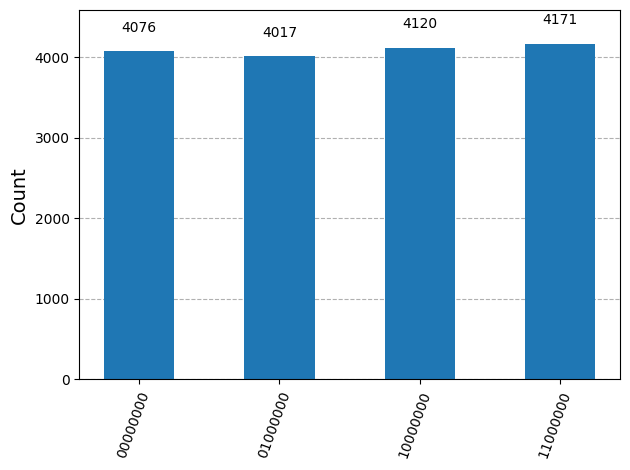

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt
from qiskit.visualization import plot_histogram
from IPython.display import display

fig = plot_histogram(counts)
        